# 1. Import some necessary modules

In [1]:
from tqdm import tqdm

import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn

import torchvision.models as models
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import transforms

# 2. Load trained model and transform the fully connected layers

In [3]:
class Net(nn.Module):
    def __init__(self , pretrained=True):
        super(Net, self).__init__()
        #Remove the last two layers of the model
        model = models.resnet18(pretrained=pretrained)
        self.resnet_layer = nn.Sequential(*list(model.children())[:-2])
        
        self.fc = nn.Linear(512*2*2, 3)
        
    def forward(self, x):
        
        x = self.resnet_layer(x)
        x = x.view(x.size(0), -1) 
        x = self.fc(x)
        
        return x

In [4]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
trained_model = torch.load('resnet18_0.9326.model')
trained_model.eval()
trained_model = trained_model.to(device)

convLayers = nn.Sequential(*list(trained_model.children())[:-1])

conv_fc = nn.Conv2d(in_channels=512, out_channels=3, kernel_size=2, stride=1)
conv_fc.load_state_dict({"weight":trained_model.fc.state_dict()['weight'].view(3, 512, 2, 2),
                       "bias":trained_model.fc.state_dict()['bias']})
conv_fc = conv_fc.to(device)

# 3. Test the transformed model

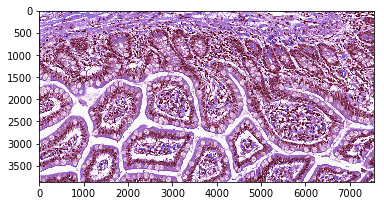

In [5]:
image = cv2.imread('Test_ROIs/test_input_he/26.png')
resized_w = image.shape[1]
resized_h = image.shape[0]
plt.imshow(image)

In [6]:
sub_num = 1

transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

X_temp = None
Y_temp = None

with tqdm(total=sub_num*sub_num) as pbar:
    for y in range(sub_num):
        for x in range(sub_num):
            xs = int(resized_w*x/sub_num)
            ys = int(resized_h*y/sub_num)
            ws = int(resized_w/sub_num)
            hs = int(resized_h/sub_num)
            sub_image = image[ys:ys+hs, xs:xs+ws, :]
            _image_tensor = transformation(sub_image).float()
            image_tensor = _image_tensor.unsqueeze_(0)

            if torch.cuda.is_available():
                image_tensor = image_tensor.to(device)

            inputs = Variable(image_tensor)
            with torch.no_grad():
                output1 = convLayers(inputs)
                _output2 = conv_fc(output1)
                output2 = F.softmax(_output2, dim=1)

            if X_temp is not None:
                X_temp = torch.cat([X_temp,output2],3)
            else:
                X_temp = output2
            pbar.update(1)

        if Y_temp is not None:
            Y_temp = torch.cat([Y_temp,X_temp],2)
        else:
            Y_temp = X_temp
        X_temp = None

100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


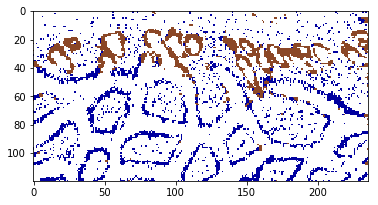

In [7]:
_out = Y_temp.squeeze_(0).data.cpu().numpy()

out_pos = _out.transpose((1,2,0))[:,:,1]
out_neg = _out.transpose((1,2,0))[:,:,0]
out_mask = _out.transpose((1,2,0))[:,:,2] > 0.6
color_out = np.zeros([_out.shape[1],_out.shape[2],3],'uint8')

thresh = 0.3
color_out[:,:,0][out_pos<out_neg] = 160
color_out[:,:,1][out_pos<out_neg] = 0
color_out[:,:,2][out_pos<out_neg] = 0

color_out[:,:,0][out_pos>out_neg] = 38
color_out[:,:,1][out_pos>out_neg] = 71
color_out[:,:,2][out_pos>out_neg] = 139

color_out[:,:,0][out_mask] = 255
color_out[:,:,1][out_mask] = 255
color_out[:,:,2][out_mask] = 255

cv2.imwrite('infer_out.png', color_out)
plt.imshow(cv2.cvtColor(color_out,cv2.COLOR_BGR2RGB))

# 4. Calculate the statistical indexes of H&E stained ROIs

In [8]:
sub_num = 1

transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def HE_calc(img_path):
    save_dir = 'Test_ROIs/test_output/HE/'
    img_name = img_path.split('/')[-3] + '_' + img_path.split('/')[-1]

    image = cv2.imread(img_path)
    resized_w = image.shape[1]
    resized_h = image.shape[0]

    X_temp = None
    Y_temp = None

    for y in range(sub_num):
        for x in range(sub_num):
            xs = int(resized_w*x/sub_num)
            ys = int(resized_h*y/sub_num)
            ws = int(resized_w/sub_num)
            hs = int(resized_h/sub_num)
            sub_image = image[ys:ys+hs, xs:xs+ws, :]
            _image_tensor = transformation(sub_image).float()
            image_tensor = _image_tensor.unsqueeze_(0)

            if torch.cuda.is_available():
                image_tensor = image_tensor.to(device)

            inputs = Variable(image_tensor)
            with torch.no_grad():
                output1 = convLayers(inputs)
                _output2 = conv_fc(output1)
                output2 = F.softmax(_output2, dim=1)

            if X_temp is not None:
                X_temp = torch.cat([X_temp,output2],3)
            else:
                X_temp = output2

        if Y_temp is not None:
            Y_temp = torch.cat([Y_temp,X_temp],2)
        else:
            Y_temp = X_temp
        X_temp = None
    
    _out = Y_temp.squeeze_(0).data.cpu().numpy().argmax(0)
    out = Y_temp.squeeze_(0).data.cpu().numpy()
    color_out = np.zeros([out.shape[1],out.shape[2],3],'uint8')
    out_pos = out[1]
    out_neg = out[0]
    out_mask = out[2] > 0.6
    thresh = 0.3
    
    color_out[:,:,0][out_pos<thresh] = 160
    color_out[:,:,1][out_pos<thresh] = 0
    color_out[:,:,2][out_pos<thresh] = 0

    color_out[:,:,0][out_pos>thresh] = 38
    color_out[:,:,1][out_pos>thresh] = 71
    color_out[:,:,2][out_pos>thresh] = 139

    color_out[:,:,0][out_mask] = 255
    color_out[:,:,1][out_mask] = 255
    color_out[:,:,2][out_mask] = 255
    
    #cv2.imwrite(save_dir + img_name[:-len('.png')] + '_out.png', color_out)

    pos_res = (color_out[:,:,0] == 38).astype(np.uint8)
    pos_dense = np.average(pos_res)

    neg_res = (color_out[:,:,0] == 160).astype(np.uint8) 
    neg_dense = np.average(neg_res)

    pos_ratio = pos_dense / (pos_dense + neg_dense)
    
    return pos_dense, neg_dense, pos_ratio

In [9]:
HE_list = glob.glob('Test_ROIs/test_input_he/*.png')

HE_list.sort()
HE_Dpos = []
HE_Dneg = []
HE_Rpos = []

with tqdm(total=len(HE_list)) as pbar:
    for img_path in HE_list:
        img_name = img_path.split('/')[-3] + '_' + img_path.split('/')[-1]
        pbar.set_description('processing %s' % img_name)
        pos_dense, neg_dense, pos_ratio = HE_calc(img_path)
        HE_Dpos.append(pos_dense)
        HE_Dneg.append(neg_dense)
        HE_Rpos.append(pos_ratio)
        pbar.update(1)

processing Test_ROIs_9.png: 100%|██████████| 32/32 [01:36<00:00,  3.02s/it] 


# 5. Calculate the statistical indexes of Ki-67 stained ROIs

In [10]:
def IHC_calc(img_path):
    save_dir = 'Test_ROIs/test_output/Ki67/'
    img_name = img_path.split('/')[-3] + '_' + img_path.split('/')[-1]

    img = cv2.imread(img_path)
    color_out = np.zeros(list(img.shape),'uint8') + 255

    # negative mask and negative dense
    neg_lower = np.array([150,0,0])
    neg_upper = np.array([255,255,160])
    neg_mask = cv2.inRange(img,neg_lower,neg_upper)
    neg_dense = np.average(neg_mask/255)

    #positive mask and positive dense
    pos_lower = np.array([0,0,0])
    pos_upper = np.array([160,255,255])
    pos_mask = cv2.inRange(img,pos_lower,pos_upper)
    pos_dense = np.average(pos_mask/255)

    color_out[:,:,0][neg_mask==255] = 160
    color_out[:,:,1][neg_mask==255] = 0
    color_out[:,:,2][neg_mask==255] = 0

    color_out[:,:,0][pos_mask==255] = 38
    color_out[:,:,1][pos_mask==255] = 71
    color_out[:,:,2][pos_mask==255] = 139

    #cv2.imwrite(save_dir + img_name[:-len('.png')] + '_out.png', color_out)
    pos_ratio = pos_dense / (pos_dense + neg_dense)
    
    return pos_dense, neg_dense, pos_ratio

In [11]:
IHC_list = glob.glob('Test_ROIs/test_input_ki67/*.png')
IHC_list.sort()
IHC_Dpos = []
IHC_Dneg = []
IHC_Rpos = []
with tqdm(total=len(IHC_list)) as pbar:
    for img_path in IHC_list:
        img_name = img_path.split('/')[-3] + '_' + img_path.split('/')[-1]
        pbar.set_description('processing %s' % img_name)
        pos_dense, neg_dense, pos_ratio = IHC_calc(img_path)
        IHC_Dpos.append(pos_dense)
        IHC_Dneg.append(neg_dense)
        IHC_Rpos.append(pos_ratio)
        pbar.update(1)

processing Test_ROIs_9.png: 100%|██████████| 32/32 [00:52<00:00,  1.63s/it] 


# 6. Plot correlation plots and frequency histograms

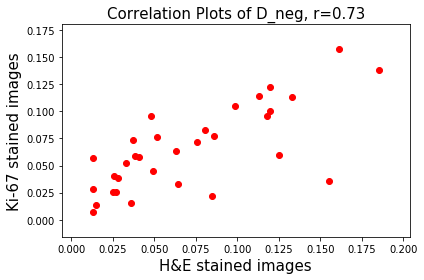

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# x = np.array(HE_Dpos)
# y = np.array(IHC_Dpos)

x = np.array(HE_Dneg)
y = np.array(IHC_Dneg)

# x = np.array(HE_Rpos)
# y = np.array(IHC_Rpos)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_title('Correlation Plots of D_neg, r=0.73', fontsize=15)
plt.xlabel('H&E stained images', fontsize=15)
plt.ylabel('Ki-67 stained images', fontsize=15)
ax1.scatter(x,y,c = 'r',marker = 'o')

plt.tight_layout()
plt.savefig("CorrelationD_neg.png",bbox_inches='tight', dpi=600,pad_inches=0.0)
plt.show()

/home/dell/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


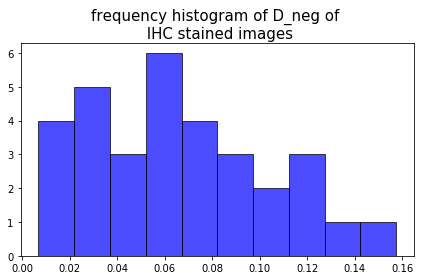

In [13]:
# x = np.array(HE_Dpos)
# y = np.array(IHC_Dpos)

x = np.array(HE_Dneg)
y = np.array(IHC_Dneg)

# x = np.array(HE_Rpos)
# y = np.array(IHC_Rpos)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_title('frequency histogram of D_neg of \n IHC stained images', fontsize=15)
ax1.hist(y, bins=10, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)

plt.tight_layout()
plt.savefig("IHCD_neg.png",bbox_inches='tight', dpi=600,pad_inches=0.0)
plt.show()